In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/AAIC/Kin

/content/drive/My Drive/AAIC/Kin


#                   **Recognizing Faces in the Wild (Kinship detection)**   

#**1. Business problem**

##**1.1 Description**

 Blood relatives often share facial features. Now researchers at Northeastern University want to improve their algorithm for facial image classification to bridge the gap between research and other familial markers like DNA results. That will be your challenge in this new Kaggle competition.

An automatic kinship classifier has been in the works at Northeastern since 2010. Yet this technology remains largely unseen in practice for a couple of reasons:

1. Existing image databases for kinship recognition tasks aren't large enough to capture and reflect the true data distributions of the families of the world.

2. Many hidden factors affect familial facial relationships, so a more discriminant model is needed than the computer vision algorithms used most often for higher-level categorizations (e.g. facial recognition or object classification).

In 2019, North Eastern Lab conducted a competition on kaggle to get help from outside world to build a more complex model by determining if two people are blood-related based solely on images of their faces. 

**Problem statement**

*   Predict whether two persons share kinship between them based solely on their facial images



##**1.2 Real world/Business Objectives and Constraints**



*   No latency requirements.
*   Return probability scores



#**2.Machine Learning Probelm**

##**2.1 Data**

###**2.1.1. Data Overview**



*   Source:https://www.kaggle.com/c/recognizing-faces-in-the-wild/data
*   Data provided by the NELab contains train data, test data , relationships. Train data contains pictures of people's faces along with their family and member ids. While test data simply contains pictures of random people.



## **2.2 Mapping the real world problem to an ML problem**

### **2.2.1 Type of Machine Leaning Problem**

This problem can be posed as a binary classification problem with the categories being related and non-related.

### **2.2.2 Performance Metric**

*  Area Under ROC curve



#**3.Data Preprocessing and EDA**

In [0]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict
from glob import glob

In [5]:
!pip install keras_vggface

In [6]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Conv1D,Concatenate, Multiply, Subtract, Add , GlobalMaxPool2D, GlobalAvgPool2D, MaxPooling2D,AveragePooling2D,Average,Reshape
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace 

Using TensorFlow backend.


In [7]:
#collecting all the names of images present in the train folder to a single file
images_list = glob("train/" + "*/*/*.jpg")
#creating two separate lists out of it. One for train and another one for validation
images_train_list = []
images_val_list = []
for x in tqdm(images_list):
  #as every item in the images_list is a string , if the substring 'F09' present in a certain item of the images_list it falls into images_val_list.
  #So basically images which are under families starting with F09 comes under validation set
  if 'F09' not in x:
    images_train_list.append(x)
  else:
    images_val_list.append(x)

100%|██████████| 12379/12379 [00:00<00:00, 1367429.27it/s]


In [8]:
print(len(images_train_list))
print(len(images_val_list))

11232
1147


In [9]:
fam_mem_id_all = []
#collecting family id and member id of all the images. This will be helpful later in this notebook
for i in images_list:
  string = i.split('/')[1]+'/'+i.split('/')[2]
  fam_mem_id_all.append(string)
  
fam_mem_id_all[0]

'F0002/MID3'

In [10]:
len(fam_mem_id_all)

12379

In [0]:
#defaultdict() is a normal dictionary (dict) but it returns a default value for a non-existent key instead of raising key error.
#The argument 'list' states that for a unique key given the dict returns a list of values
#Now 2 such dicts are created to map family member id (key) with all the images of him/her (values). One for train and another for validation data
image_dict_train = defaultdict(list)
for i in images_train_list:
   image_dict_train[i.split("/")[1] + "/" + i.split("/")[2]].append(i)

In [0]:
image_dict_val = defaultdict(list)
for i in images_val_list:
   image_dict_val[i.split("/")[1] + "/" + i.split("/")[2]].append(i)

In [13]:
print(len(image_dict_train))
print(len(image_dict_val))

2085
231


In [14]:
[v for v in list(image_dict_train.values())[:3]]

[['train/F0002/MID3/P00011_face3.jpg',
  'train/F0002/MID3/P00013_face3.jpg',
  'train/F0002/MID3/P00014_face1.jpg',
  'train/F0002/MID3/P00015_face1.jpg',
  'train/F0002/MID3/P00009_face1.jpg',
  'train/F0002/MID3/P00010_face1.jpg',
  'train/F0002/MID3/P00018_face2.jpg',
  'train/F0002/MID3/P00017_face1.jpg'],
 ['train/F0002/MID1/P00016_face2.jpg',
  'train/F0002/MID1/P00009_face3.jpg',
  'train/F0002/MID1/P00015_face2.jpg',
  'train/F0002/MID1/P00012_face2.jpg',
  'train/F0002/MID1/P00013_face2.jpg',
  'train/F0002/MID1/P00017_face3.jpg',
  'train/F0002/MID1/P00011_face1.jpg',
  'train/F0002/MID1/P00014_face2.jpg',
  'train/F0002/MID1/P00010_face4.jpg',
  'train/F0002/MID1/P00018_face1.jpg'],
 ['train/F0002/MID2/P00012_face1.jpg',
  'train/F0002/MID2/P00011_face2.jpg',
  'train/F0002/MID2/P00010_face3.jpg',
  'train/F0002/MID2/P00013_face1.jpg',
  'train/F0002/MID2/P00016_face1.jpg',
  'train/F0002/MID2/P00017_face2.jpg',
  'train/F0002/MID2/P00015_face4.jpg',
  'train/F0002/MID2/P00

In [0]:
data_df = pd.read_csv('train_relationships.csv')
#zip to zip each pair in the data. When iteration is done through it , it iterates through pairs
data_df_pair_list = list(zip(data_df['p1'].values, data_df['p2'].values))
#getting those pairs which are actually present in the data. Some of them are missing.fam_mem_id_all contains all the ids/folders that are present in the data.
all_present_pair_list = []
for i in data_df_pair_list:
  if i[0] in fam_mem_id_all and i[1] in fam_mem_id_all:
    all_present_pair_list.append(i)

In [0]:
train_pairs = []
val_pairs = []
#creating tuples which are kins
for i in all_present_pair_list:
  if 'F09' not in i[0]:
    train_pairs.append(i)
  else:
    val_pairs.append(i)

In [17]:
print(len(train_pairs))
print(len(val_pairs))

3066
296


In [18]:
train_pairs[0:3]

[('F0002/MID1', 'F0002/MID3'),
 ('F0002/MID2', 'F0002/MID3'),
 ('F0005/MID1', 'F0005/MID2')]

In [19]:
val_pairs[0:3]

[('F0900/MID2', 'F0900/MID1'),
 ('F0900/MID3', 'F0900/MID1'),
 ('F0901/MID1', 'F0901/MID4')]

In [0]:
# code credits https://github.com/nyoki-mtl/keras-facenet/blob/master/notebook/demo-images.ipynb
# 2 pretrained face models are used to build the model. Facenet and vgg face -resnet 50
# prewhiten is a image preprocessing function related to facenet.It returns preprocessed images that are fed as input to facenet.

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

In [0]:
#A helper function to fetch preprocessed images for facenet
import cv2
def getimage_fn(path):
    img = cv2.imread(path)
    img = cv2.resize(img,(160,160))
    img = np.array(img).astype(np.float)
    return prewhiten(img)

In [0]:
# A helper function to fetch preprocessed images for vgg model
from keras_vggface.utils import preprocess_input
def getimage_vgg(path):
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

In [0]:
# generator to generate a batch of data tuples 
# code inspired from https://medium.com/analytics-vidhya/kinship-classification-using-vggface-a7c76f81288
def generator(data_list, data_dict, batch_size=16):
    data_members = list(data_dict.keys())
    #This generator should have a infinite loop so that it can yield batches as long as the fit_generator method is running
    while 1: 
        sample_list = random.sample(data_list, batch_size // 2)
        l = [1] * len(sample_list)
        while len(sample_list) < batch_size:
            p1 = random.choice(data_members)
            p2 = random.choice(data_members)

            if p1 != p2 and (p1, p2) not in data_list and (p2, p1) not in data_list:
                sample_list.append((p1, p2))
                l.append(0)

        for i in sample_list:
            if not len(data_dict[i[0]]):
                print(i[0])

        X1 = [random.choice(data_dict[x[0]]) for x in sample_list]
        image_fn_1 = np.array([getimage_fn(x) for x in X1])
        image_vgg_1 = np.array([getimage_vgg(x) for x in X1])

        X2 = [random.choice(data_dict[x[1]]) for x in sample_list]
        image_fn_2 = np.array([getimage_fn(x) for x in X2])
        image_vgg_2 = np.array([getimage_vgg(x) for x in X2])

        yield [image_vgg_1,image_vgg_2,image_fn_1,image_fn_2], l

In [0]:
#building model
pre_face = VGGFace(model='resnet50', include_top=False)
for x in pre_face.layers[:-3]:
    x.trainable = True

from keras.models import load_model
face_net = load_model('facenet_keras.h5')
for layer in face_net.layers:
    layer.trainable = True

image_1_vgg = Input(shape=(224, 224, 3))
image_2_vgg = Input(shape=(224, 224, 3))
image_1_fn = Input(shape=(160, 160, 3))
image_2_fn = Input(shape=(160, 160, 3))

out_1_vgg = pre_face(image_1_vgg)
out_2_vgg = pre_face(image_2_vgg)
out_1_fn = face_net(image_1_fn)
out_2_fn = face_net(image_2_fn)

gmax_Avg_vgg1 = out_1_vgg
gmax_Avg_vgg2 = out_2_vgg    
out_1_fn_rs = Reshape((1, 1 ,128))(out_1_fn)
out_2_fn_rs = Reshape((1, 1 ,128))(out_2_fn)
gmax_Avg_fn1 = Concatenate(axis=-1)([GlobalMaxPool2D()(out_1_fn_rs), GlobalAvgPool2D()(out_1_fn_rs)])
gmax_Avg_fn2 = Concatenate(axis=-1)([GlobalMaxPool2D()(out_2_fn_rs), GlobalAvgPool2D()(out_2_fn_rs)])

#gmax_Avg_vgg1 = Concatenate(axis=-1)([GlobalMaxPool2D()(out_1_vgg), GlobalAvgPool2D()(out_1_vgg)])
#gmax_Avg_vgg2 = Concatenate(axis=-1)([GlobalMaxPool2D()(out_2_vgg), GlobalAvgPool2D()(out_2_vgg)])

    
add_fn = Add()([gmax_Avg_fn1 , gmax_Avg_fn2])
add_vgg = Add()([gmax_Avg_vgg1 , gmax_Avg_vgg2])
sub_fn = Subtract()([gmax_Avg_fn1,gmax_Avg_fn2])
sub_vgg = Subtract()([gmax_Avg_vgg1,gmax_Avg_vgg2])
mul_fn = Multiply()([gmax_Avg_fn1,gmax_Avg_fn2])
mul_vgg = Multiply()([gmax_Avg_vgg1,gmax_Avg_vgg2])
avg_fn = Average()([gmax_Avg_fn1,gmax_Avg_fn2])
avg_vgg = Average()([gmax_Avg_vgg1,gmax_Avg_vgg2])
    
conv_add_vgg = Conv2D(128 , [1,1] )(add_vgg)
conv_sub_vgg = Conv2D(128 , [1,1] )(sub_vgg)
conv_mul_vgg = Conv2D(128 , [1,1] )(mul_vgg)
conv_avg_vgg = Conv2D(128 , [1,1] )(avg_vgg)
    
all_fs = Concatenate(axis=-1)([Flatten()(conv_add_vgg), (add_fn), Flatten()(conv_sub_vgg), (sub_fn),
                                   Flatten()(conv_mul_vgg), (mul_fn),Flatten()(conv_avg_vgg), (avg_fn)]) 
                                  
    
d1 = Dense(100, activation="relu")(all_fs)
do1 = Dropout(0.1)(d1)
d2 = Dense(32, activation="relu")(do1)
do2 = Dropout(0.1)(d2)
out = Dense(1, activation="sigmoid")(do2)

model = Model([image_1_vgg, image_2_vgg, image_1_fn, image_2_fn], out)














94699520/94694792 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
____________________________________________________________________________________________

In [0]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
model.compile(loss="binary_crossentropy",optimizer=Adam(0.00001),metrics=['acc'])

In [0]:
import threading
from keras.callbacks import ReduceLROnPlateau
lr = ReduceLROnPlateau(monitor='val_acc', mode='max',patience=10,factor=0.5,verbose=1)
from keras.callbacks import ModelCheckpoint
ckpt = ModelCheckpoint('fn_vgg_new.h5', mode='max', verbose=1,monitor='val_acc', save_best_only= True)

In [0]:
inspect = model.fit_generator(generator(train_pairs, image_dict_train, batch_size=16), use_multiprocessing=True,
                    validation_data=generator(val_pairs, image_dict_val, batch_size=16), epochs=40, verbose=1,
                    workers = 4, callbacks=[lr, ckpt], steps_per_epoch=200, validation_steps=100)

Epoch 1/40
200/200 [==============================] - 604s 3s/step - loss: 0.8244 - acc: 0.5697 - val_loss: 0.7347 - val_acc: 0.5938

Epoch 00001: val_acc improved from -inf to 0.59375, saving model to fn_vgg_new.h5
Epoch 2/40
200/200 [==============================] - 264s 1s/step - loss: 0.6714 - acc: 0.6181 - val_loss: 0.6438 - val_acc: 0.6475

Epoch 00002: val_acc improved from 0.59375 to 0.64750, saving model to fn_vgg_new.h5
Epoch 3/40
200/200 [==============================] - 216s 1s/step - loss: 0.6186 - acc: 0.6738 - val_loss: 0.6196 - val_acc: 0.6713

Epoch 00003: val_acc improved from 0.64750 to 0.67125, saving model to fn_vgg_new.h5
Epoch 4/40
200/200 [==============================] - 215s 1s/step - loss: 0.5805 - acc: 0.6816 - val_loss: 0.5748 - val_acc: 0.6937

Epoch 00004: val_acc improved from 0.67125 to 0.69375, saving model to fn_vgg_new.h5
Epoch 5/40
200/200 [==============================] - 215s 1s/step - loss: 0.5616 - acc: 0.6972 - val_loss: 0.5808 - val_acc: 0

In [0]:
model.save("fn_vgg_new_100_epoch.h5")

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
def plt_dynamic1(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Accuracy")
    ax.plot(x, ty, 'r', label="Training Accuracy")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

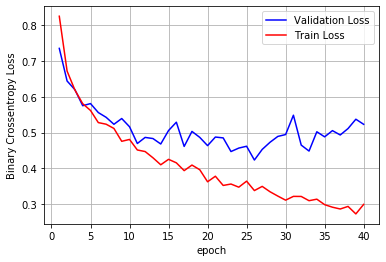

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,41))
vl = inspect.history['val_loss']
tl = inspect.history['loss']
plt_dynamic(x, vl, tl, ax)

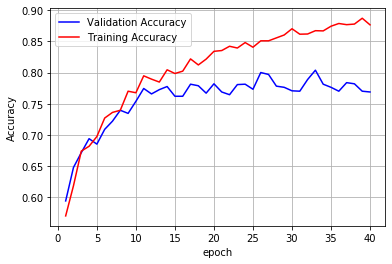

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
x = list(range(1,41))
vacc = inspect.history['val_acc']
tacc = inspect.history['acc']
plt_dynamic1(x, vacc, tacc, ax)

In [0]:
from keras.models import load_model
fn_vgg_new_best= load_model('fn_vgg_new.h5')

Using TensorFlow backend.














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
predictions = []
chunksize =100
df = 'sample_submission.csv'
for chunk in tqdm(pd.read_csv(df,chunksize=chunksize)):
    batch = chunk.img_pair.values
    X1 = [x.split("-")[0] for x in batch]
    image_fn_1 = np.array([getimage_fn('test/' + x) for x in X1])
    image_vgg_1 = np.array([getimage_vgg('test/' + x) for x in X1])
    X2 = [x.split("-")[1] for x in batch]
    image_fn_2 = np.array([getimage_fn('test/' + x) for x in X2])
    image_vgg_2 = np.array([getimage_vgg('test/' + x) for x in X2])
    prediction = fn_vgg_new_best.predict([image_vgg_1,image_vgg_2,image_fn_1,image_fn_2]).ravel().tolist()
    predictions += prediction


0it [00:00, ?it/s]
1it [01:05, 65.28s/it]
2it [02:32, 71.89s/it]
3it [03:55, 75.17s/it]
4it [05:31, 81.30s/it]
5it [06:46, 79.43s/it]
6it [08:06, 79.74s/it]
7it [09:22, 78.52s/it]
8it [10:34, 76.63s/it]
9it [11:46, 75.29s/it]
10it [12:51, 72.04s/it]
11it [13:58, 70.66s/it]
12it [14:57, 67.03s/it]
13it [16:06, 67.75s/it]
14it [17:12, 67.34s/it]
15it [18:12, 65.11s/it]
16it [19:11, 63.34s/it]
17it [20:11, 62.23s/it]
18it [21:10, 61.23s/it]
19it [22:06, 59.74s/it]
20it [23:06, 59.70s/it]
21it [23:57, 57.18s/it]
22it [24:51, 56.28s/it]
23it [25:35, 52.46s/it]
24it [26:22, 50.77s/it]
25it [27:20, 53.02s/it]
26it [28:09, 51.84s/it]
27it [28:49, 48.26s/it]
28it [29:40, 49.17s/it]
29it [30:30, 49.47s/it]
30it [31:15, 47.94s/it]
31it [31:58, 46.65s/it]
32it [32:39, 44.73s/it]
33it [33:20, 43.55s/it]
34it [34:05, 44.09s/it]
35it [34:44, 42.57s/it]
36it [35:23, 41.58s/it]
37it [36:07, 42.35s/it]
38it [36:42, 40.00s/it]
39it [37:26, 41.29s/it]
40it [38:03, 39.97s/it]
41it [38:43, 39.89s/it]
42it 

In [0]:
result = pd.read_csv('sample_submission.csv')
result['is_related'] = predictions
result.to_csv("fn_vgg_new_best.csv", index= False)

In [0]:
fn_vgg_new_100_epoch = load_model('fn_vgg_new_100_epoch.h5')

In [0]:
predictions = []
chunksize =100
df = 'sample_submission.csv'
for chunk in tqdm(pd.read_csv(df,chunksize=chunksize)):
    batch = chunk.img_pair.values
    X1 = [x.split("-")[0] for x in batch]
    image_fn_1 = np.array([getimage_fn('test/' + x) for x in X1])
    image_vgg_1 = np.array([getimage_vgg('test/' + x) for x in X1])
    X2 = [x.split("-")[1] for x in batch]
    image_fn_2 = np.array([getimage_fn('test/' + x) for x in X2])
    image_vgg_2 = np.array([getimage_vgg('test/' + x) for x in X2])
    prediction = fn_vgg_new_100_epoch.predict([image_vgg_1,image_vgg_2,image_fn_1,image_fn_2]).ravel().tolist()
    predictions += prediction


0it [00:00, ?it/s]
1it [00:20, 20.44s/it]
2it [00:25, 15.71s/it]
3it [00:28, 12.02s/it]
4it [00:31,  9.44s/it]
5it [00:35,  7.64s/it]
6it [00:38,  6.41s/it]
7it [00:42,  5.51s/it]
8it [00:45,  4.88s/it]
9it [00:49,  4.43s/it]
10it [00:52,  4.13s/it]
11it [00:56,  3.95s/it]
12it [00:59,  3.79s/it]
13it [01:02,  3.66s/it]
14it [01:06,  3.57s/it]
15it [01:09,  3.55s/it]
16it [01:13,  3.50s/it]
17it [01:16,  3.46s/it]
18it [01:19,  3.42s/it]
19it [01:23,  3.44s/it]
20it [01:26,  3.42s/it]
21it [01:30,  3.45s/it]
22it [01:33,  3.49s/it]
23it [01:37,  3.53s/it]
24it [01:40,  3.48s/it]
25it [01:44,  3.45s/it]
26it [01:47,  3.44s/it]
27it [01:50,  3.43s/it]
28it [01:54,  3.42s/it]
29it [01:57,  3.42s/it]
30it [02:01,  3.43s/it]
31it [02:04,  3.43s/it]
32it [02:08,  3.43s/it]
33it [02:11,  3.40s/it]
34it [02:14,  3.40s/it]
35it [02:18,  3.40s/it]
36it [02:21,  3.38s/it]
37it [02:24,  3.37s/it]
38it [02:28,  3.38s/it]
39it [02:31,  3.38s/it]
40it [02:35,  3.40s/it]
41it [02:38,  3.43s/it]
42it 

In [0]:
result = pd.read_csv('sample_submission.csv')
result['is_related'] = predictions
result.to_csv("fn_vgg_new_100_epoch.csv", index= False)

#COMBINED MODELS

## 1st Combined Model

In [0]:
first = pd.read_csv('fn_vgg_new_best.csv')
second = pd.read_csv('fn_vgg_new_100_epoch.csv')

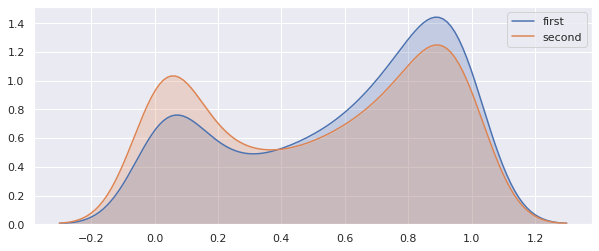

In [0]:
sns.set(rc={'figure.figsize':(10,4)})
sns.kdeplot(first['is_related'],label="first",shade= True,bw=.1)
sns.kdeplot(second['is_related'], label="second",shade= True,bw=.1)

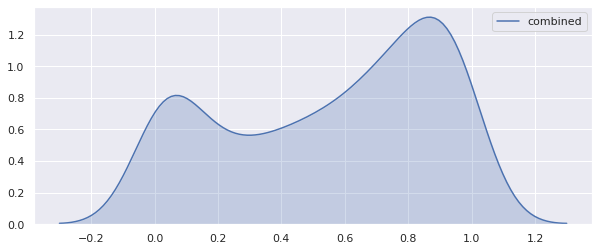

In [0]:
result = pd.read_csv('sample_submission.csv')
result['is_related'] = 0.50*first['is_related'] + 0.50*second['is_related']
sns.kdeplot(result['is_related'],label="combined",shade= True,bw=.1)
plt.show()

## 2nd Combined Model

In [0]:
result.to_csv('fn_vgg_new_combined_1.csv', index= False)

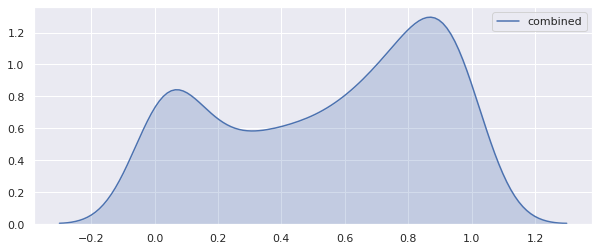

In [0]:
result = pd.read_csv('sample_submission.csv')
result['is_related'] = 0.40*first['is_related'] + 0.60*second['is_related']
sns.kdeplot(result['is_related'],label="combined",shade= True,bw=.1)
plt.show()

In [0]:
result.to_csv('fn_vgg_new_combined_2.csv', index= False)

## 3rd Combined Model

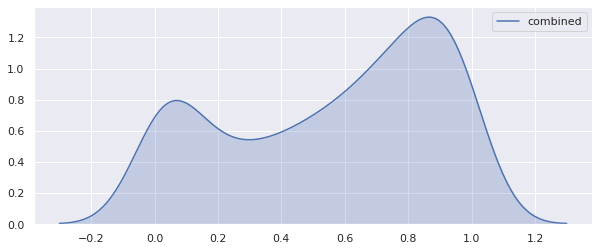

In [0]:
result = pd.read_csv('sample_submission.csv')
result['is_related'] = 0.60*first['is_related'] + 0.40*second['is_related']
sns.kdeplot(result['is_related'],label="combined",shade= True,bw=.1)
plt.show()

In [0]:
result.to_csv('fn_vgg_new_combined_3.csv', index= False)

#EVALUATING MODEL 1(BEST WEIGHTS) 
#KAGGLE SCORES-> 0.865 (Public), 0.868 (Private)

In [0]:
from keras.models import load_model
fn_vgg_new_best= load_model('fn_vgg_new.h5')

In [0]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from sklearn.metrics import roc_auc_score
import tensorflow as tf
#auroc metric
def aucc(y_true, y_pred):
   if len(np.unique(y_true)) == 1:
      return 0.5
   else:
      return roc_auc_score(y_true, y_pred)
def auroc(y_true, y_pred):
    return tf.py_func(aucc, (y_true, y_pred), tf.double)

In [31]:
fn_vgg_new_best.compile(loss="binary_crossentropy",optimizer=Adam(0.00001),metrics=['accuracy',auroc])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [33]:
# This evaluating generator returns metrics such as Loss(Binary cross entropy),Accuracy , AUROC Score in order
#Evaluating on Train Data
fn_vgg_new_best.evaluate_generator(generator(train_pairs, image_dict_train, batch_size=16), steps = 200)

[0.3187491707876325, 0.8671875, 0.95484375]

In [35]:
# This evaluating generator returns metrics such as Loss(Binary cross entropy),Accuracy , AUROC Score in order
#Evaluating on Validation Data
fn_vgg_new_best.evaluate_generator(generator(val_pairs, image_dict_val, batch_size=16), steps = 100)

[0.45022138968110087, 0.798125, 0.870625]

#EVALUATING MODEL 2( WEIGHTS AFTER 40 EPOCHS)
#KAGGLE SCORES-> 0.874 (Public) , 0.877 (Private)

In [0]:
fn_vgg_new_40_epoch = load_model('fn_vgg_new_100_epoch.h5')

In [0]:
fn_vgg_new_40_epoch.compile(loss="binary_crossentropy",optimizer=Adam(0.00001),metrics=['accuracy',auroc])

In [43]:
# This evaluating generator returns metrics such as Loss(Binary cross entropy),Accuracy , AUROC Score in order
#Evaluating on Train Data
fn_vgg_new_40_epoch.evaluate_generator(generator(train_pairs, image_dict_train, batch_size=16), steps = 200)

[0.2613425075262785, 0.8953125, 0.9646875]

In [41]:
# This evaluating generator returns metrics such as Loss(Binary cross entropy),Accuracy , AUROC Score in order
#Evaluating on Validation Data
fn_vgg_new_40_epoch.evaluate_generator(generator(val_pairs, image_dict_val, batch_size=16), steps = 100)

[0.4811488364636898, 0.780625, 0.8709375]

#EVALUATING COMBINED MODEL 1 
#KAGGLE SCORES -> 0.880 (Public) , 0.881 (Private)

In [78]:
predictions = []
lables = []
for i in tqdm(range(0,100)):
  samples , l = next(generator(val_pairs, image_dict_val, batch_size=16))
  pred = 0.50*fn_vgg_new_best.predict(samples) + 0.50*fn_vgg_new_40_epoch.predict(samples)
  predictions += pred.ravel().tolist()
  lables += l
AUROC = auroc(lables,predictions)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print('The AUROC is ',AUROC.eval())

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


The AUROC is  0.8825468750000001


#EVALUATING COMBINED MODEL 2
#KAGGLE SCORES-> 0.880 (Public) , 0.881 (Private)

In [79]:
predictions = []
lables = []
for i in tqdm(range(0,100)):
  samples , l = next(generator(val_pairs, image_dict_val, batch_size=16))
  pred = 0.40*fn_vgg_new_best.predict(samples) + 0.60*fn_vgg_new_40_epoch.predict(samples)
  predictions += pred.ravel().tolist()
  lables += l
AUROC = auroc(lables,predictions)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print('The AUROC is ',AUROC.eval())

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


The AUROC is  0.8867046875


#EVALUATING COMBINED MODEL 3
#KAGGLE SCORES-> 0.879 (Public) , 0.880 (Private)

In [80]:
predictions = []
lables = []
for i in tqdm(range(0,100)):
  samples , l = next(generator(val_pairs, image_dict_val, batch_size=16))
  pred = 0.60*fn_vgg_new_best.predict(samples) + 0.40*fn_vgg_new_40_epoch.predict(samples)
  predictions += pred.ravel().tolist()
  lables += l
AUROC = auroc(lables,predictions)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print('The AUROC is ',AUROC.eval())

100%|██████████| 100/100 [01:05<00:00,  1.48it/s]


The AUROC is  0.8763453124999999
